In [1]:
# Initialize Otter
import otter
grader = otter.Notebook("cs109b_hw1.ipynb")

# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS109B Data Science 2: Advanced Topics in Data Science 
## Homework 1 - Clustering




**Harvard University**<br/>
**Spring 2023**<br/>
**Instructors**: Mark Glickman & Pavlos Protopapas 


<hr style="height:2pt">

In [2]:
# RUN THIS CELL 
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

<hr>

#### Instructions
- To submit your assignment follow the instructions given in Canvas.
- Plots should be legible and interpretable without having to refer to the code that generated them, including labels for the $x$- and $y$-axes as well as a descriptive title and/or legend when appropriate.
- When asked to interpret a visualization, do not simply describe it (e.g., "the curve has a steep slope up"), but instead explain what you think the plot *means*.
- Autograding tests are mostly to help you debug. The tests are not exhaustive so passing a test is necessary but not sufficient for full credit. 
- The use of *extremely* inefficient or error-prone code (e.g., copy-pasting nearly identical commands rather than looping) may result in only partial credit.
- We have tried to include all the libraries you may need to do the assignment in the imports cell provided below. Please get course staff approval before importing any additional 3rd party libraries.
- Enable scrolling output on cells with very long output.
- Feel free to add additional code or markdown cells as needed.
- Ensure your code runs top to bottom without error and passes all tests by restarting the kernel and running all cells (note that this can take a few minutes). 
- **You should do a "Restart Kernel and Run All Cells" before submitting to ensure (1) your notebook actually runs and (2) all output is visible**

<hr>

### Import Libraries

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

from gap_statistic import OptimalK
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import dendrogram, fcluster, ward
from scipy.cluster import hierarchy
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [4]:
# measure notebook runtime
time_start = time.time()


<hr style="height:2pt">

<a id="contents"></a>

# Notebook Contents

- [**Problem 1 [37.5 pts]: Clustering with k-means**](#part1)

- [**Problem 2 [37.5 pts]: Other Ks**](#part2)
  
- [**Problem 3 [25 pts]: Alternative Algorithms**](#part3)


<div class="theme">FMA: A Dataset For Music Analysis </div>

In this assignment, you will be working with data collected from The Free Music Archive (https://freemusicarchive.org/). The Free Music Archive is an online repository of original music from independent artists that can be freely downloaded as an mp3. 

The provided `fma_new.csv` contains 9,354 rows.

In this subset of the FMA data, each music track is represented by a total of 82 summary audio features:

8 interpretable features extracted by Echonest (now Spotify):\
`acousticness`, `danceability`, `energy`, `instrumentalness`, `liveness`, `speechiness`, `tempo`, `valence`


74 abstract audio features computated across the run time of the track using the [librosa](https://librosa.org/doc/latest/index.html) python package and then averaged. 

For those interestend in more information about the FMA dataset please see the paper and GitHub repository (https://github.com/mdeff/fma)

<a id="part1"></a>

## <div class='exercise'>Part 1: Clustering with k-means </div>

[Return to contents](#contents)

<!-- BEGIN QUESTION -->

<div class='exercise'><b>Q1.1 Loading Data, Scaling, and KMeans Clustering</b></div>
    
Begin by reading `data/fma_new.csv` into a Pandas DataFrame called `fma`.  

You can assume that this particular subset of the FMA data includes 12 different music genres. So we'll begin by assuming there are 12 clusters. 

But before we begin clustering we should standardize the dataset so that all features have mean of 0 and standard deviation of 1. In this way the distance metric used by out clustering algorithms will not be affect by the arbitrary scale of the features. Save the standardized data in DataFrame called `fma_scaled` which has the same column names as `fma`.

Next, run the k-means clustering algorithm on the scaled data using the `KMeans` class from `sklearn.cluster`, setting the number of clusters to 12, `n_init` to 25, and the `random_state` to 109.  Save the fitted KMeans object as `km12`.

In [5]:
# your code here

fma = pd.read_csv("/Users/jamesliounis/Documents/Harvard SM DS/AC209b/Problem Sets/cs109b_hw1/data/fma_new.csv")

# Standardizing dataset

# Create standard scaler object
scale = StandardScaler()

# Apply to df
fma_scaled = pd.DataFrame(scale.fit_transform(fma), columns = fma.columns)

In [6]:
# your code here

# Save the fitted KMeans object 
km12 = KMeans(n_clusters = 12, n_init = 25, random_state = 109).fit(fma_scaled)

In [7]:
grader.check("q1.1")

q1.1 results: All test cases passed!

<!-- BEGIN QUESTION -->

<!-- BEGIN QUESTION -->

<div class='exercise'><b>Q1.2 Evaluating $k=12$</b></div>

The provided `silplot` function creates two subplots: one displays the silhouette scores for each datapoint across all clusters and the other shows a projection of the data onto its first 2 principal components. In both subplots the assigned cluster labels are encoded by color.

How reasonable does the clustering with $k=12$ appear? Use your understanding of the silhouette scores and PCA projection to support your position.

In [8]:
#modified code from http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html

def silplot(X, cluster_labels, clusterer, pointlabels=None):
    n_clusters = clusterer.n_clusters
    
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(12,7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example we 
    # will set a lower limit on the x-axis to keep the plot small
    ax1.set_xlim([-0.2, 1])
    
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print(f"For n_clusters = {n_clusters}, the average silhouette_score is {silhouette_avg}.")

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(0,n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = plt.cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.2, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = plt.cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    
    # axes will be first 2 PCA components
    
    pca = PCA(n_components=2).fit(X.values)
    X_pca = pca.transform(X.values) 
    ax2.scatter(X_pca[:, 0], X_pca[:, 1], marker='.', s=200, lw=0, alpha=0.35,
                c=colors, edgecolor='k')
    xs = X_pca[:, 0]
    ys = X_pca[:, 1]    

    
    if pointlabels is not None:
        for i in range(len(xs)):
            plt.text(xs[i],ys[i],pointlabels[i])

    # Labeling the clusters (transform to PCA space for plotting)
    centers = pca.transform(clusterer.cluster_centers_)
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % int(i), alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("PC1 ({}%)".format(np.round(100*pca.explained_variance_ratio_[0],1)))
    ax2.set_ylabel("PC2 ({}%)".format(np.round(100*pca.explained_variance_ratio_[1],1)))

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

**Answer to Q1.2**

Considering the clustering visualization alongside the silhouette score enables us to conclude that the clustering with $k = 12$ is *not* very reasonable. There are multiple reasons for this:
- Setting $k = 12$ does not allow for a clear separation of clusters. Data points are overlapping, meaning the clustering is unclear
- The red vertical line in the silhouette plot denotes the 'average silhouette score'. A fair amount of clusters here have many points which are to the left of that line i.e., below the average silhouette score (if the silhouette score of an observation is below the average silhouette score of all observations, it means that the observation is not well-matched to its own cluster and might be better assigned to a different cluster)
- A lot of clusters even have *negative* silhouette scores: this indicates that an observation is poorly matched to its assigned cluster, meaning it is more similar to other observations in a different cluster than to its own cluster, which depicts the aforementioned "overlap"
- The compactness of the clusters is clearly unequal: cluster 4 seems to be significantly larger than 3, 2, and 0, for example

For n_clusters = 12, the average silhouette_score is 0.04987327481584193.


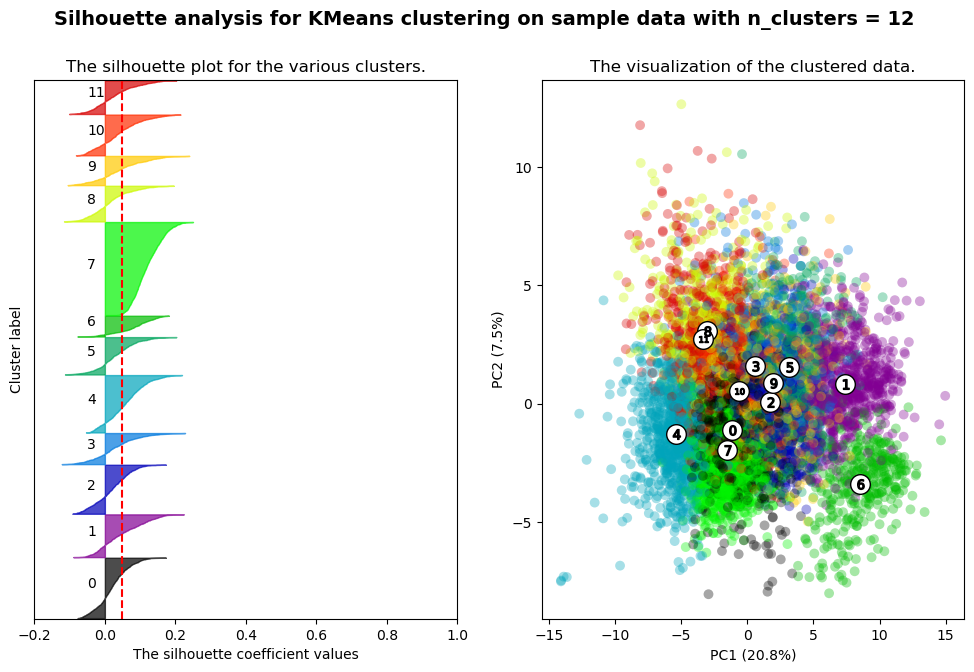

In [9]:
# your code here
silplot(fma_scaled, km12.labels_, km12, pointlabels=None)

<!-- END QUESTION -->

<a id="part2"></a>

## <div class='exercise'>Part 2: Other Ks </div>

[Return to contents](#contents)

Our choice of $k=12$ was just a guess based on the fact that we've been told there are 12 genres represented in this data.\
We'll now look at some metrics we can use to evaluate a set of clusters.

**For questions in this section (Part 2) you should work with a sample of 2,000 data points drawn with the DataFrame `sample`method and a random seed of 109.**

<!-- BEGIN QUESTION -->

<!-- BEGIN QUESTION -->

<div class='exercise'><b>Q2.1 Inertia</b></div>

Here you'll use the elbow method to evaluate the best choice of $k$, plotting the total inertia of each k-means clustering for $k \in \{1,2,...,15\}.$

Running kmeans across many values of $k$ can take a long time so we'll take a few steps to speed things up.

First, you should only be clustering a subset of the scaled data in this section (part 2). Using the DataFrame's `sample` method with a `random_state` of 109, sample 2,000 data points and store them in `processed_sample`.

Next, when fiting each KMeans object, use only 10 initializations and a random state of 109 as before.

Finally, create a well labeled plot of inertia as a function of $k$ and describe what value(s) of $k$ might be considered optimal with respect to this plot and why.

**Note:** recall that inertia is twice the total within-cluster variation 

The inertia is given by:

$\text{inertia or WCSS} = \sum_{i=1}^{k} \sum_{x \in C_i} \left| x - \mu_i \right|^2$

where $C_i$ is the set of points in the $i$-th cluster, and $μ_i$ is the mean (centroid) of the $i$-th cluster.

From the expression, we can see that the inertia measures the sum of squared distances between each data point and its nearest cluster center. As the number of clusters increases, the inertia decreases as the clusters become smaller and tighter. However, beyond a certain point, the decrease in the inertia slows down and levels off, which corresponds to the optimal number of clusters. Thus, finding the optimal-$k$ is equivalent to finding the elbow or knee point in the plot of the inertia as a function of the number of clusters. This corresponds to the number of clusters that provides a good balance between the loss of information caused by having too few clusters and the increase in complexity caused by having too many clusters.

In this case, $k=2$ and $k=4$ seem to be good choices, but the kink is more defined for the former, suggesting that it is the optimal number of clusters. 

In [10]:
# your code here

processed_sample = fma_scaled.sample(n=2000, random_state = 109)

In [11]:
# Create a function to train the KMeans algorithm

def train_kmeans(X, k):
    # Implementing required specifications
    kmeans = KMeans(n_clusters = k, random_state = 109, n_init = 10)
    # Training on data
    kmeans.fit(X)
    return kmeans

ks = [i for i in range(1, 16)]

# Saving ks and fitted models in a dictionary in order to reuse later
model_dic = {f"k={k}":train_kmeans(processed_sample, k) for k in ks}

# Saving inertias in a separate object
inertias = [model.inertia_ for model in model_dic.values()]

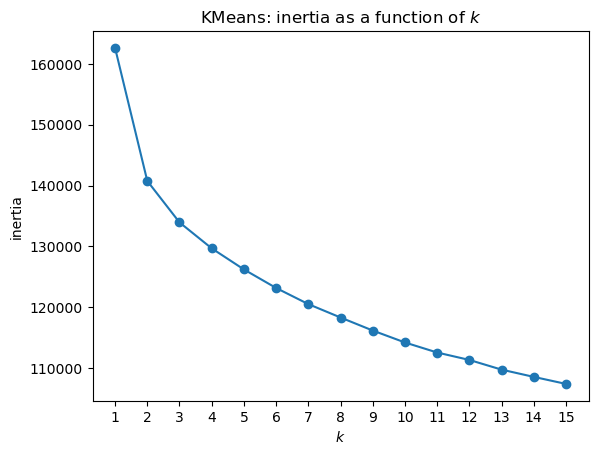

In [12]:
plt.plot(ks, inertias, 'o-')
plt.xticks(ks);
plt.xlabel('$k$')
plt.ylabel('inertia')
plt.title('KMeans: inertia as a function of $k$');

In [13]:
grader.check("q2.1")

q2.1 results: All test cases passed!

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<div class='exercise'><b>Q2.2 Silhouette Score</b></div>

Using the labels from each of the 15 fitted KMeans objects in the previous question, calculate the average silhouette scores and store them in `sil_scores`. 

Plot the average silhouette scores in `sil_scores` as a function of $k$. Describe what value(s) of $k$ might be considered optimal with respect to this plot and why.

**Hints:**
* If you stored your results from Q2.1 you shouldn't have to refit any KMeans objects here
* `silhouette_score` will throw an error if you try and score labels containing only a single cluster. Note that the silhouette score when $k=1$ is definte to be 0.

**Answer to Q2.2**

Given a set of N data points, the silhouette score for each observation i is defined as:

$s_i = \frac{b_i - a_i}{\max(a_i, b_i)}$

where $a_i$ is the average distance between observation $i$ and all other observations in the same cluster, and $b_i$ is the minimum average distance between observation $i$ and observations in all other clusters.

Using once again the "elbow method", we look for a kink in the below plot, where the average silhouette score starts to decline or level off. This corresponds to the number of clusters that provides a good balance between the loss of information caused by having too few clusters and the increase in complexity caused by having too many clusters.

This is clearly the case for $k=2$. 

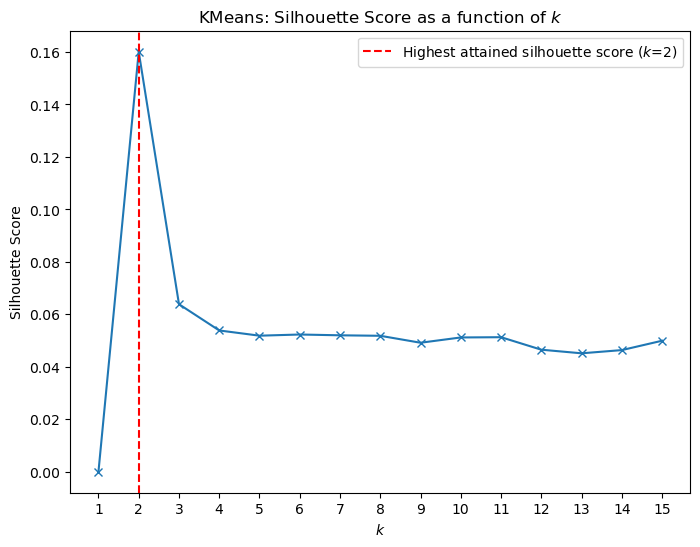

In [62]:
sil_scores = []


# Iterating through the previously trained models that are stored in a dictionary
for model in model_dic.values():
    
    # We start by trying to append silhouette scores whenever possible
    try:
        sil_scores.append(silhouette_score(processed_sample, model.labels_)) 
    # In the event of ValueError, set silhouette score to 0 as per instructions
    except ValueError:
        sil_scores.append(0)

# Plot

# Setting figure size
plt.figure(figsize=(8, 6))
# Plot silhouette scores as a function of number of clusters
plt.plot(ks, sil_scores, 'x-')

# Evidencing highest silhouette score, marking it clearly on plot
plt.axvline(ks[np.argmax(sil_scores)], c='r', ls='--', 
            label=f"Highest attained silhouette score ($k$={ks[np.argmax(sil_scores)]})")
plt.xticks(ks);
plt.xlabel('$k$')
plt.ylabel('Silhouette Score')
plt.title('KMeans: Silhouette Score as a function of $k$')
plt.legend();

In [15]:
grader.check("q2.2")

q2.2 results: All test cases passed!

<!-- BEGIN QUESTION -->

<!-- BEGIN QUESTION -->

<div class='exercise'><b>Q2.3 Gap Statistic</b></div>

Use the gap statistic to evaluate the choice of the number of clusters for k-means clustering with $k \in \{1,2,..,15\}$. Again, use `processed_sample` rather than the entire dataset to save time. 

Create a well-labeled plot showing the gap statistic as a function of the number of clusters.

Describe the rule for picking the optimum number of clusters described in [the original gap statistic paper](https://hastie.su.domains/Papers/gap.pdf) (this is the method referred to in lecture as allowing for some "slack").

**Note:** This implementation of gap statistic has a [difficulties with reproducibility](https://github.com/milesgranger/gap_statistic/issues/59) so don't worry if your results change across runs. Setting a random seed with numpy and setting OptimalK's `n_jobs=1` helps, but it makes everything run unbearably slow. 

**Hint:** The [gap_statistic GitHub repo](https://github.com/milesgranger/gap_statistic) is a good place to find information about the `OptimalK` object and its attributes.

In [16]:
# to ignore the frame.append warning described here:
# https://github.com/milesgranger/gap_statistic/issues/57
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

**Answer to Q2.3**

According to the Tibshirani et al. paper, the Gap statistic measures the difference between the WCSS of observed data and an expected WCSS under a null reference distribution. It helps determine the best number of clusters in a data set by comparing the WCSS of observed data with the WCSS of the reference distribution (often assumed to be a *uniform* distribution). 

The formula for calculating Gap statistic is: 

$$Gap(k) = E_n^{}logW_k^{} - logW_k$$

where $k$ represents the number of clusters, $W_k$ is the WCSS (see previous WCSS equation) of observed data with $k$ clusters, and $E_n^{}logW_k^{}$ is the expected WCSS under the reference distribution.

The optimal number of clusters is the value of $k$ at which the Gap statistic first starts to level off and no longer increases as $k$ increases. This value is typically identified by looking for an "elbow" in the Gap statistic plot.

In [64]:
# your code here

# instantiate OptimalK with recommended specification
optimalK = OptimalK(n_jobs = 1)

# Calling OptimalK

#`n_refs` specifies the number of reference datasets 
# used to compute the Gap statistic  
# `cluster_array` refers to the potential number of clusters, passed in array form
n_clusters = optimalK(processed_sample, cluster_array = np.array(ks), n_refs=500)

print('Optimal number of clusters:', n_clusters)

Optimal number of clusters: 15


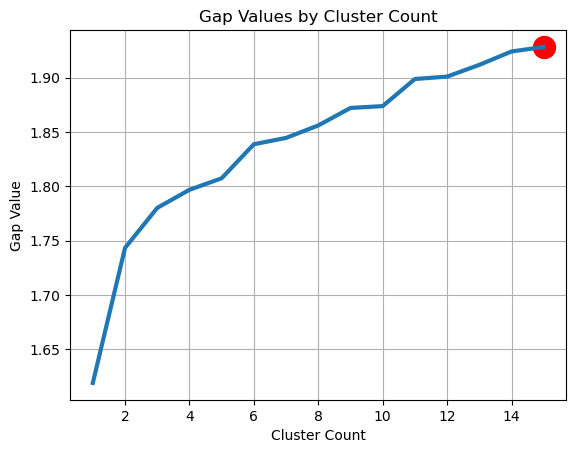

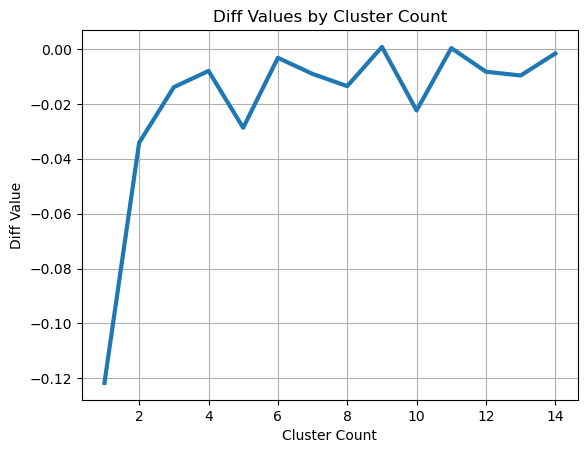

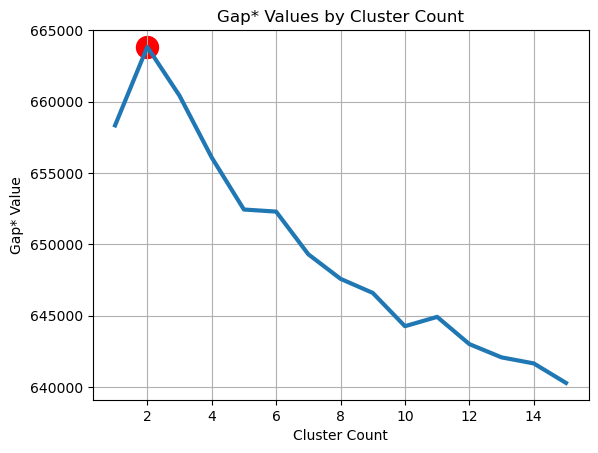

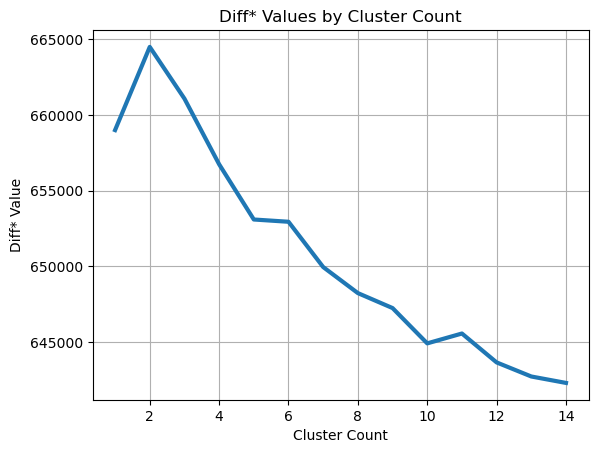

In [65]:
optimalK.plot_results()

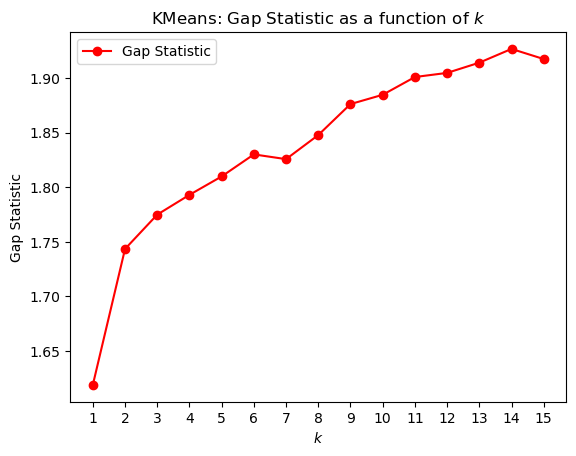

In [19]:
# Plot
plt.plot(ks, gap_statistics, 'o-', color='red', label='Gap Statistic')
plt.xticks(ks);
plt.xlabel('$k$')
plt.ylabel('Gap Statistic')
plt.title('KMeans: Gap Statistic as a function of $k$')
plt.legend();

In [20]:
# Need to be skeptical about the gap statistic, focus on distribution
# Slack method

In [21]:
# your code here
# Use the stopping condition described in the original paper
...

Ellipsis

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<!-- BEGIN QUESTION -->

<div class='exercise'><b>Q2.4 Choose a Best $k$</b></div>

After analyzing the plots produced by all three of these metrics, discuss the number of k-means clusters that you think is the best fit for this dataset. Defend your answer with evidence from the three graphs produced here and what you surmise about this dataset. Store your choice in `best_k`.

_Type your answer here, replacing this text._

In [22]:
best_k = 15

In [23]:
grader.check("q2.4")

q2.4 results: All test cases passed!

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<div class='exercise'><b>Q2.5 Visualize & Interpret Best $k$ Results</b></div>

Fit KMeans on the *entire scaled dataset* using your choice of `best_k`, 25 initializations, and a random state of 109. Store the KMeans object in `km_best` and the resulting labels in `km_labels`. 

Next, use `silplot` to visualize these clusters and their silhouette scores. 

How do these plots differ from the previous pair, and what might that mean about the clusterings? Would you consider your kmeans clustering with `best_k` successful?

_Type your answer here, replacing this text._

In [48]:
km_best

KMeans(n_clusters=2, n_init=25, random_state=109)

In [49]:
# your code here

km_best = KMeans(n_clusters = best_k, n_init = 25, random_state = 109).fit(fma_scaled)
km_labels = km_best.labels_

For n_clusters = 15, the average silhouette_score is 0.04457540784896917.


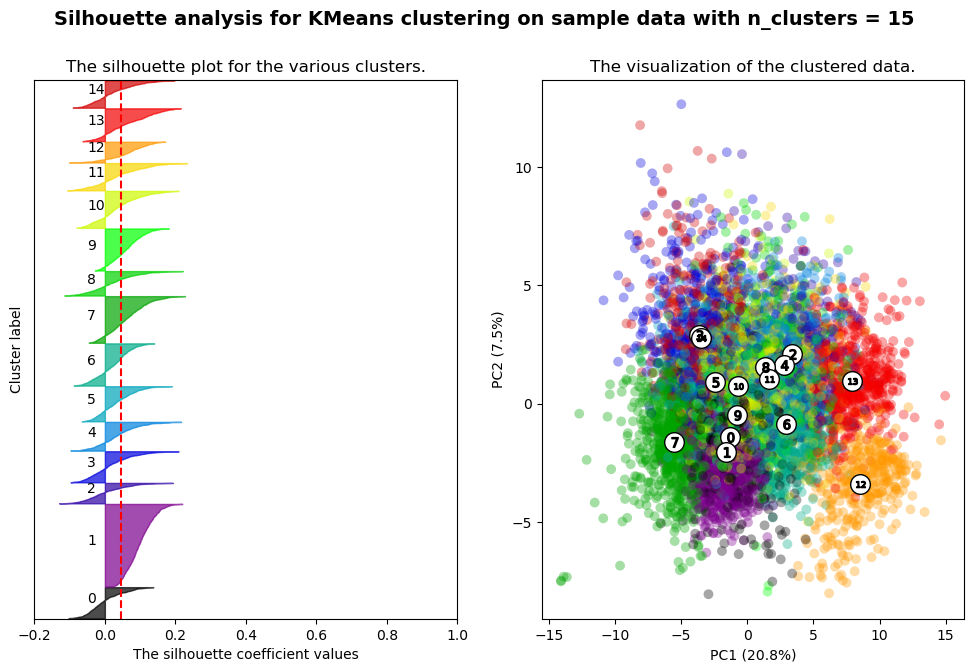

In [50]:
silplot(fma_scaled, km_labels, km_best, pointlabels=None)

In [51]:
grader.check("q2.5")

q2.5 results: All test cases passed!

<a id="part3"></a>

## <div class='exercise'>Part 3: Alternative Algorithms </div>

[Return to contents](#contents)

<!-- BEGIN QUESTION -->

<!-- BEGIN QUESTION -->

<div class='exercise'><b>Q3.1: Hierarchical Clustering</b></div>

Run agglomerative clustering using Ward's method and plot the result using a dendrogram.

Next, create a well-labeled plot of average silhoutte score as a function of the number of clusters, again with $k \in \{1,2,..,15\}$. To do this you'll need to produce a series of 'flat' cluster labels using `fcluster` for each value of $k$ and then use those labels to calculate the averate silhouette scores.

Use information from the dedrogram and silhouette scores plot to justify a choice for the optimal number of clusters. Store this interger in `maxclust`. Then use  to find the 'flat' cluster labels produced when `maxclust` is used as the maximum number of clusters. Store these labels in `hac_labels`.

**Hint:**
- When using a lot of data, rendering an x-axis label for each observation can make the dendrogram plotting very slow. Try setting `no_labels=True`.
- Inspect the unique cluster labels produced by `fcluster`. Notice how they are numbered. Keep this in mind as you may need to alter the labels if you plan to use them with functions that expect labels to be encoded like those from KMeans.

_Type your answer here, replacing this text._

In [27]:
# your code here

# Create condensed distance matrix from fma dataset

y = pdist(fma_scaled)

# Perform clustering
Z = ward(y)

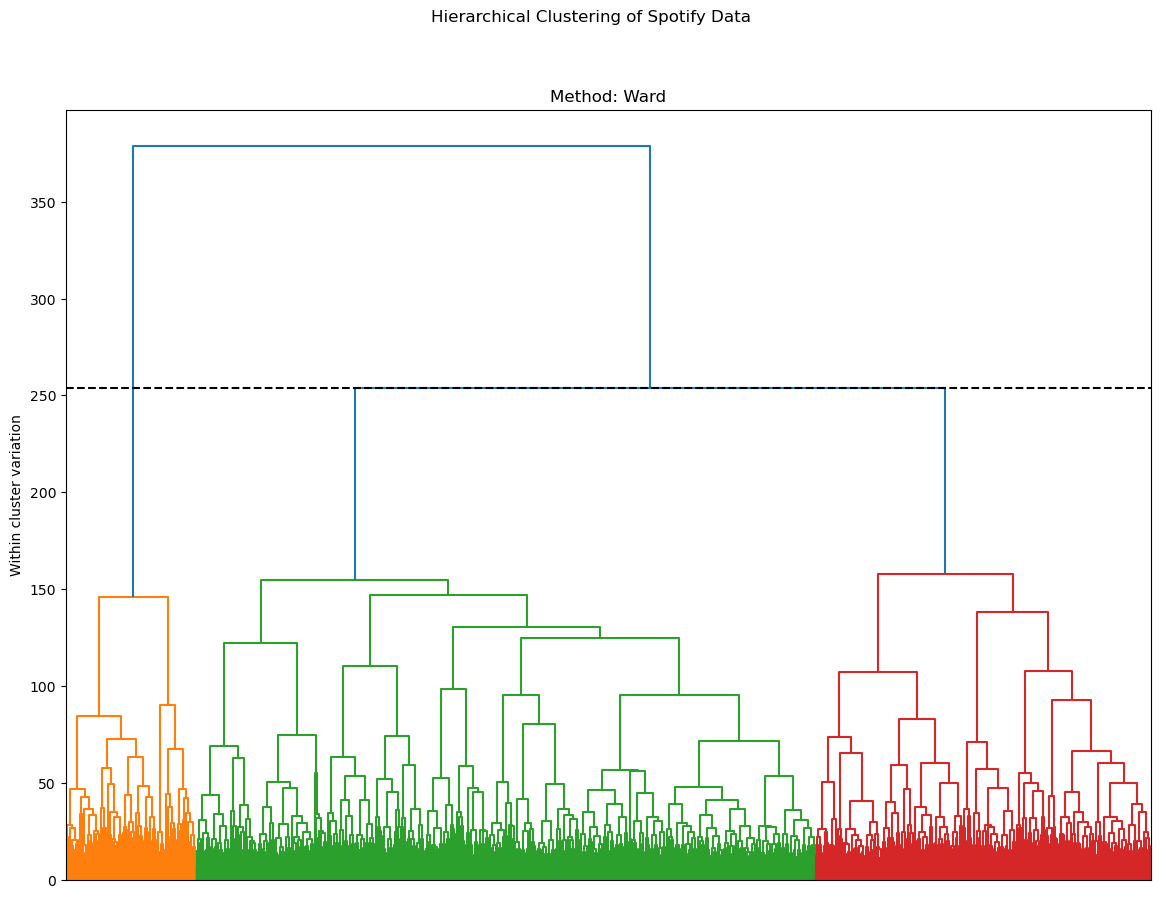

In [28]:
# number of clusters
k = 3

plt.figure(figsize=(14,10))


# threshold where we 'cut' the dendrogram
thresh = Z[-(k-1),2]
# draw dendrogram
dendrogram(Z, color_threshold=thresh, no_labels=True)

# show a subset of xtick labels so it isn't too cluttered
ticks, labels = plt.xticks()
step = 5
plt.xticks(ticks[::step], labels[::step], fontsize=13)

# horizontal line at threshold
plt.axhline(thresh, ls='--', c='k');
plt.suptitle("Hierarchical Clustering of Spotify Data")
plt.ylabel("Within cluster variation")
plt.title("Method: Ward");

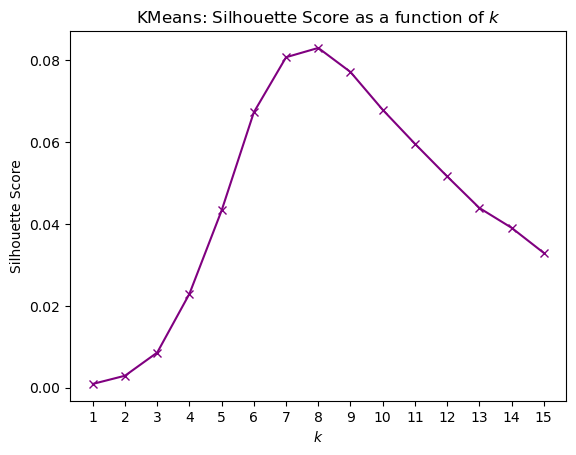

In [29]:
# Calculating flat cluster for each k

fclusters = {f"k={k}":fcluster(Z, k, criterion='distance') for k in ks}

sil_scores = []
        
for model in fclusters.values():
    sil_scores.append(silhouette_score(fma_scaled, model))

# Plot
plt.plot(ks, sil_scores, 'x-', color='purple')
plt.xticks(ks);
plt.xlabel('$k$')
plt.ylabel('Silhouette Score')
plt.title('KMeans: Silhouette Score as a function of $k$');

In [30]:
maxclust = 8
hac_labels = fclusters['k=8']

In [31]:
grader.check("q3.1")

q3.1 results: All test cases passed!

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<!-- BEGIN QUESTION -->

<div class='exercise'><b>Q3.2: DBSCAN</b></div>

Create a well-labeled knee plot to determine an optimal epsilon for when the min point parameter is 5. Then run DBSCAN on the data using your choice of `episilon` and the speficied `min_samples=5`.

Store all labels produced in `dbscan_labels`.\
Store the number of *clusters* found by the algorithm in `dbscan_n_clusters`.

Inspect the number of points that were assigned to each *label*. What does this tell you about the clusters and give a geometric interpretation of what kind of data might lead to this result of DBSCAN?

_Type your answer here, replacing this text._

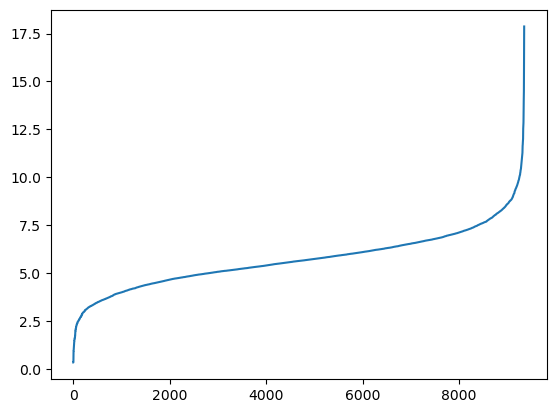

In [32]:
# your code here
neighbors = NearestNeighbors(n_neighbors=20)
neighbors_fit = neighbors.fit(fma_scaled)
distances, indices = neighbors_fit.kneighbors(fma_scaled)


distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances);

In [33]:
# your code here
...

In [34]:
# your code here
...

In [35]:
...

Ellipsis

In [36]:
grader.check("q3.2")

q3.2 results:
    q3.2 - 1 result:
        Trying:
            assert (np.unique(dbscan_labels) >= 0).sum() == dbscan_n_clusters,\
                "Your dbscan_n_clusters is incorrect. Think about what the label values mean."
        Expecting nothing
        **********************************************************************
        Line 1, in q3.2 0
        Failed example:
            assert (np.unique(dbscan_labels) >= 0).sum() == dbscan_n_clusters,\
                "Your dbscan_n_clusters is incorrect. Think about what the label values mean."
        Exception raised:
            Traceback (most recent call last):
              File "/opt/anaconda3/lib/python3.9/doctest.py", line 1334, in __run
                exec(compile(example.source, filename, "single",
              File "<doctest q3.2 0[0]>", line 1, in <module>
                assert (np.unique(dbscan_labels) >= 0).sum() == dbscan_n_clusters,\
            NameError: name 'dbscan_labels' is not defined
        Trying:
            assert dbscan_labels.shape[0] == fma_scaled.shape[0],\
                f"dbscan_labels should have {fma_scaled.shape[0]} elements, but it has {dbsca_labels.shape[0]}"
        Expecting nothing
        **********************************************************************
        Line 3, in q3.2 0
        Failed example:
            assert dbscan_labels.shape[0] == fma_scaled.shape[0],\
                f"dbscan_labels should have {fma_scaled.shape[0]} elements, but it has {dbsca_labels.shape[0]}"
        Exception raised:
            Traceback (most recent call last):
              File "/opt/anaconda3/lib/python3.9/doctest.py", line 1334, in __run
                exec(compile(example.source, filename, "single",
              File "<doctest q3.2 0[1]>", line 1, in <module>
                assert dbscan_labels.shape[0] == fma_scaled.shape[0],\
            NameError: name 'dbscan_labels' is not defined

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<!-- BEGIN QUESTION -->

<div class='exercise'><b>Q3.3</b></div>

Load `data/track_info.csv` into the Dataframe `track_info` and inspect it. This track info corresponds to the data in `fma` row-for-row.

Create a well-labeled plot or set of subplots that visualize the 'top genre' make-up of each cluster designated by the three sets of labels: `km_labels`, `hac_labels`, and `dbscan_labels`.

What does your visualization demonstrate about how each clustering compares to the genre labels? Does any one clustering seem more successful at capturing genre distinctions?

**Hint:** There are many ways you could approach this visuallization task. Experiment! You may also find it helpful to create plotting functions to handle some parts of the visualization if they are being repeated with slightly different parameters (e.g., cluster labels).

_Type your answer here, replacing this text._

In [37]:
...

Ellipsis

In [38]:
# your code here

<!-- END QUESTION -->

<a id="bonus"></a>

## <div class='exercise'>Wrap-up</div>

[Return to contents](#contents)

The only required section here is to report the amount of time you spent on this assignment.

You are encouraged to use this space to continue to explore the fma dataset. You could:
- Try different clustering methods (e.g., total linkage)
- Attempt feature selection, engineering, or dimentionality reduction before clustering
- Sample points from clusters and inspect their track information to get an idea what a cluster might represent
- Find the nearest neighbors in the feature space to a track of interest
- Pull in new data from the [FMA project](https://github.com/mdeff/fma). There are thousands of additional tracks to use (these were just the only ones that also had the Spotify features and track info available). And there are also hundreds of additional (abstract) audio feature columns that can be used.

How many hours did you spend working on this assignment?

In [39]:
time_spent_on_hw = ...

In [40]:
# your code here
...

In [41]:
...

Ellipsis

In [42]:
...

Ellipsis

In [43]:
grader.check("bonus")

bonus results:
    bonus - 1 result:
        Trying:
            assert float(time_spent_on_hw),\
                "Please select a time in hours (int or float) to specify how long you spent on this assignment."
        Expecting nothing
        **********************************************************************
        Line 1, in bonus 0
        Failed example:
            assert float(time_spent_on_hw),\
                "Please select a time in hours (int or float) to specify how long you spent on this assignment."
        Exception raised:
            Traceback (most recent call last):
              File "/opt/anaconda3/lib/python3.9/doctest.py", line 1334, in __run
                exec(compile(example.source, filename, "single",
              File "<doctest bonus 0[0]>", line 1, in <module>
                assert float(time_spent_on_hw),\
            TypeError: float() argument must be a string or a number, not 'ellipsis'

In [44]:
time_end = time.time()
print(f"It took {(time_end - time_start)/60:.2f} minutes for this notebook to run")

It took 2.93 minutes for this notebook to run


**This concludes HW1. Thank you!**